# Detección de tumores cerebrales en resonancias magnéticas

In [6]:
# Correr esta celda solamente en colab
!git clone https://github.com/ColossalCoin/TDA-Delfin.git
!pip install -U giotto-tda
%cd TDA-Delfin

Cloning into 'TDA-Delfin'...
Updating files:  25% (71/276)
Updating files:  26% (72/276)
Updating files:  27% (75/276)
Updating files:  28% (78/276)
Updating files:  29% (81/276)
Updating files:  30% (83/276)
Updating files:  31% (86/276)
Updating files:  32% (89/276)
Updating files:  33% (92/276)
Updating files:  34% (94/276)
Updating files:  35% (97/276)
Updating files:  36% (100/276)
Updating files:  37% (103/276)
Updating files:  38% (105/276)
Updating files:  39% (108/276)
Updating files:  40% (111/276)
Updating files:  41% (114/276)
Updating files:  42% (116/276)
Updating files:  43% (119/276)
Updating files:  44% (122/276)
Updating files:  45% (125/276)
Updating files:  46% (127/276)
Updating files:  47% (130/276)
Updating files:  48% (133/276)
Updating files:  49% (136/276)
Updating files:  50% (138/276)
Updating files:  51% (141/276)
Updating files:  52% (144/276)
Updating files:  53% (147/276)
Updating files:  54% (150/276)
Updating files:  55% (152/276)
Updating files:  56% 

C:\Users\Acer\Delfin-TDA\TDA-Delfin


## Análisis topológico de las resonancias

Comenzaremos el análisis tomando las dos primeras resonancias de de cada clase, es decir, una resonancia con tumor presente y una sin tumor. Posteriormente desarrollaremos un pipeline en el que podamos aplicar un análisis similar a todos las imágenes del conjunto de datos y entrenar un modelo de machine learning que aproveche dicho análisis.

El método central utilizado en este análisis será el cálculo de homología persistente mediante complejos cúbicos.

In [8]:
from data.image_converter import get_images

images_yes, images_no = get_images(image_size=(224, 224))

im_yes = images_yes[0]
im_no = images_no[0]

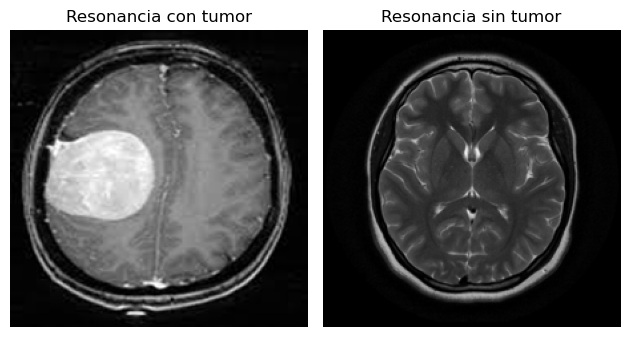

In [9]:
import matplotlib.pyplot as plt

plt.figure()

plt.subplot(1, 2, 1)
plt.title('Resonancia con tumor')
plt.imshow(im_yes, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Resonancia sin tumor')
plt.imshow(im_no, cmap='gray')
plt.axis('off')

plt.tight_layout()

### Persistencia cúbica de la imagen original

Dado que las resonancias magnéticas (MRI) son imágenes en escala de grises, el primer paso natural en la búsqueda de características topológicas es el de asociar un complejo cúbico $K$ a cada imagen $\mathcal I$ vista como función
$$
\mathcal I:I\subset\mathbb Z^2\to\mathbb R,
$$
donde cada $v\in I$ representa un píxel y el valor $\mathcal I(v)\in\mathbb R$ representa la intensidad o valor en la escala de grises. La construcción de $K$ se obtiene entonces considerando la filtración natural $\{K_i\}_{i\in\text{Im}(I)}$ dada por
$$
K_i:=\{v\in I:\mathcal I(v)\leq i\}
$$
donde $K_i$ es llamado el *$i$-ésmo conjunto de subnivel* de $K$. [[1]](https://arxiv.org/pdf/1910.08345)

In [11]:
from gtda.homology import CubicalPersistence
from gtda.diagrams import Scaler

# Redimencionamos las imagenes de acuerdo al input de los métodos fit_transform
im_yes = images_yes[0][None, :, :]
im_no = images_no[0][None, :, :]

cubical_persistence = CubicalPersistence(n_jobs=-1)
scaler = Scaler(n_jobs=-1)

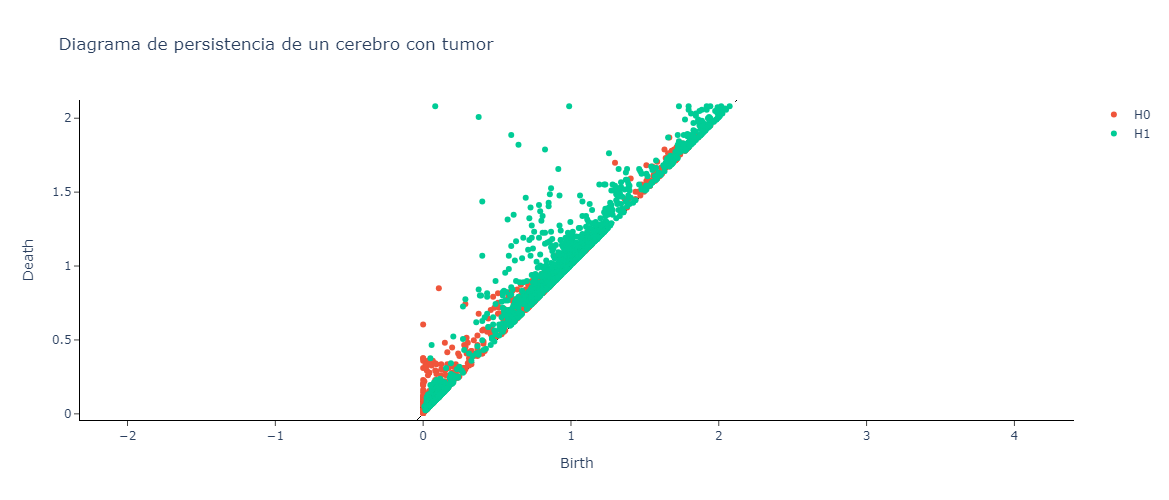

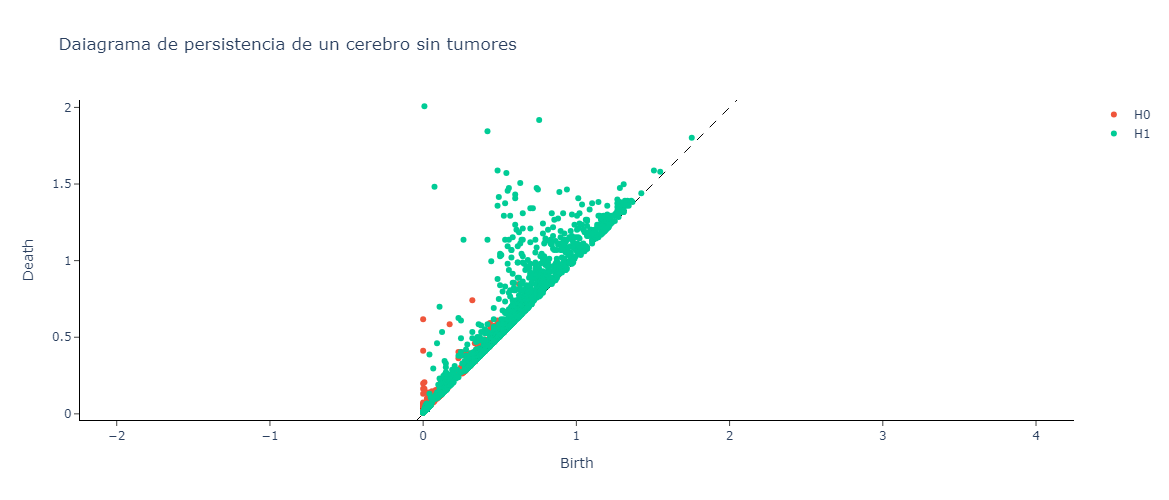

In [68]:
im_yes_cubical = cubical_persistence.fit_transform(im_yes)
im_no_cubical = cubical_persistence.fit_transform(im_no)

im_yes_scaled = scaler.fit_transform(im_yes_cubical)
im_no_scaled = scaler.fit_transform(im_no_cubical)

im_yes_scaled_plot = scaler.plot(im_yes_scaled, 
                                         plotly_params={'layout':{'title':'Diagrama de persistencia de un cerebro con tumor'}})
im_no_scaled_plot = scaler.plot(im_no_scaled, 
                                       plotly_params={'layout':{'title':'Daiagrama de persistencia de un cerebro sin tumores'}})

im_yes_scaled_plot.show()
im_no_scaled_plot.show()

En los diagramas de persistencia anteriores podemos observar diferencias en el número de puntos pertenecientes tanto a $H_0$ como a $H_1$, sin embargo, es difícil visualizar más diferencias entre estos diagramas, en parte por la gran cantidad de puntos irrelevantes (cercanos a la diagonal) presentes en ambos diagramas. De esta fomra, resulta conveniente *filtrar* el diagrama para deshacernos de los puntos más cercanos a la diagonal.

In [134]:
from gtda.diagrams import Filtering

filtering = Filtering(homology_dimensions=[0, 1], epsilon=0.1)

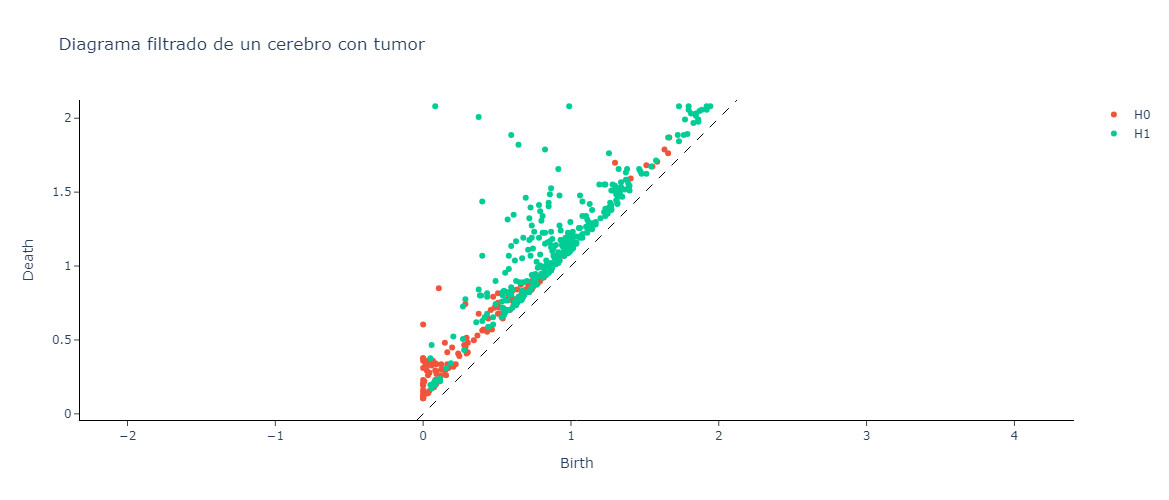

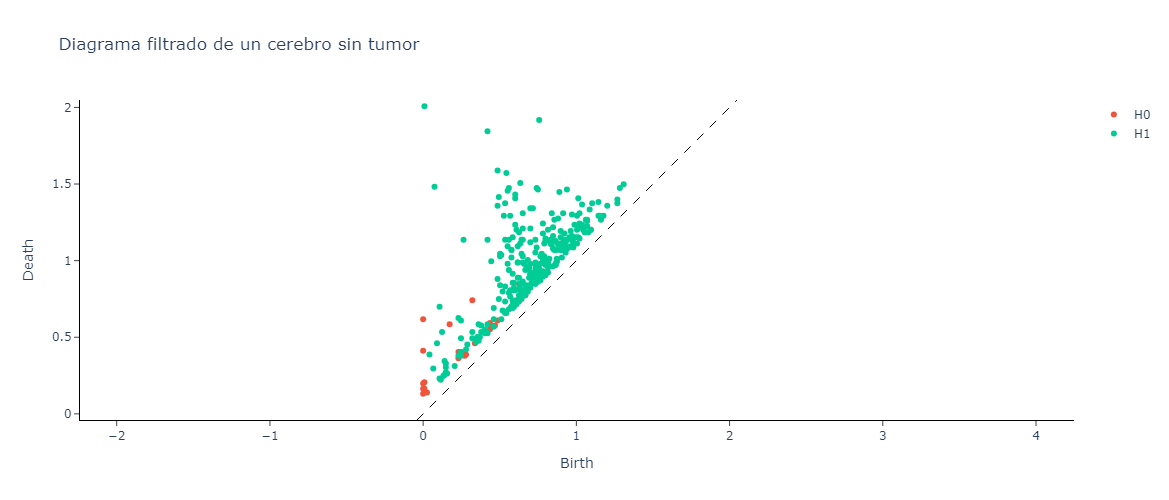

In [136]:
im_yes_filtered = filtering.fit_transform(im_yes_scaled)
im_no_filtered = filtering.fit_transform(im_no_scaled)

im_yes_filtered_plot = filtering.plot(im_yes_filtered, plotly_params={'layout':{'title':'Diagrama filtrado de un cerebro con tumor'}})
im_no_filtered_plot = filtering.plot(im_no_filtered,  plotly_params={'layout':{'title':'Diagrama filtrado de un cerebro sin tumor'}})

im_yes_filtered_plot.show()
im_no_filtered_plot.show()

Aún así, existen mejores formas de visualizar la información contenida en los diagramas de persistencia, las cuales abordaremos a continuación.

### Paisaje de persistencia
Una de las representaciones es el *paisaje de persistencia*, el cual se construye partir de un diagrama de persistencia $\mathcal D$ donde los puntos $(b,d)\in\mathcal D$ son tranformados de tal forma que
$$
(b,d)\mapsto\left(\frac{b+d}{2}, \frac{d-b}{2}\right).
$$
En esta representación se descartan los puntos con persistencia infinita. De esta forma, el *paisaje* se define a partir del conjunto de funciones creadas al rotar el diagrama de persistencia, de tal forma que
$$
\Lambda_p(t)=\begin{cases}
t-b, & t\in\left[b,\frac{b+d}{2}\right] \\
d-t, & t\in\left(\frac{b+d}{2}, d\right] \\
0,   & \text{en cualquier otro caso.}
\end{cases}
$$
Así, el paisaje de persistencia $\Lambda_{\mathcal D}$ se obtiene de superponer las gráficas de las funciones $\Lambda_p(t).$ [[2]](https://www.frontiersin.org/journals/artificial-intelligence/articles/10.3389/frai.2021.667963/full)

<center>
    <img src="Figures/landscape_example.jpg" alt="Ejemplo de un paisaje de persistencia" width=40% height=auto border=2/>
    <figcaption>Figura 1: Ejemplo de un paisaje de persistencia (derecha) a partir de un diagrama de persistencia (izquierda).</figcaption>
</center>

Conviene solo considerar una cantidad pequeña de funciones $\Lambda_p$ para facilitar la interpretación, por lo que solo consideraremos dos *capas*.

In [138]:
from gtda.diagrams import PersistenceLandscape

persistence_landscape = PersistenceLandscape(n_layers=2, n_bins=10, n_jobs=-1)

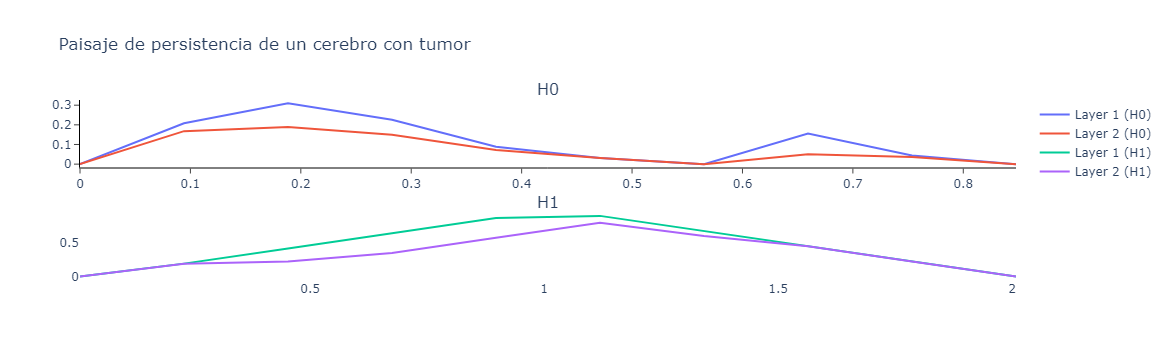

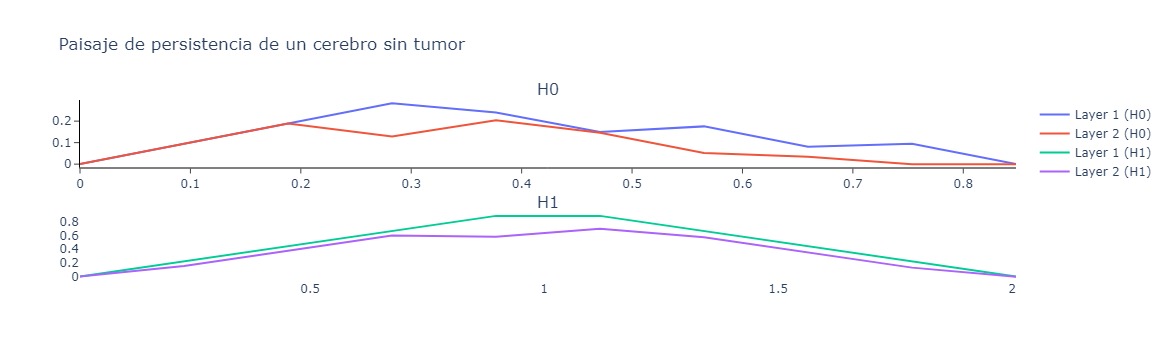

In [140]:
im_yes_landscape = persistence_landscape.fit_transform(im_yes_filtered)
im_no_landscape = persistence_landscape.fit_transform(im_no_filtered)

im_yes_landscape_plot = persistence_landscape.plot(im_yes_landscape, plotly_params={'layout':{'title':'Paisaje de persistencia de un cerebro con tumor'}})
im_no_landscape_plot = persistence_landscape.plot(im_no_landscape, plotly_params={'layout':{'title':'Paisaje de persistencia de un cerebro sin tumor'}})

im_yes_landscape_plot.show()
im_no_landscape_plot.show()

### Curvas de Betti

Definimos la curva de Betti de dimensión homológica $k$ como
$$
\beta_k(t):=\sum_{(b,d)\in\mathcal D}w(b,d)1_{t\in[b,d]}
$$
donde $w$ es la función de peso definida sobre la diagonal $\Delta$ de $\mathcal D$. Es decir, la curva de Betti es el némero de generadores en un tiempo $t$. [[2]](https://www.frontiersin.org/journals/artificial-intelligence/articles/10.3389/frai.2021.667963/full)
La información sobre la función de peso considerada en la función `BettiCurve` de `giotto-tda` puede ser encontrada en la [documentación oficial](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.BettiCurve.html#gtda.diagrams.BettiCurve) de `giotto-tda`.

In [142]:
from gtda.diagrams import BettiCurve

betti_curve = BettiCurve(n_bins=10, n_jobs=-1)

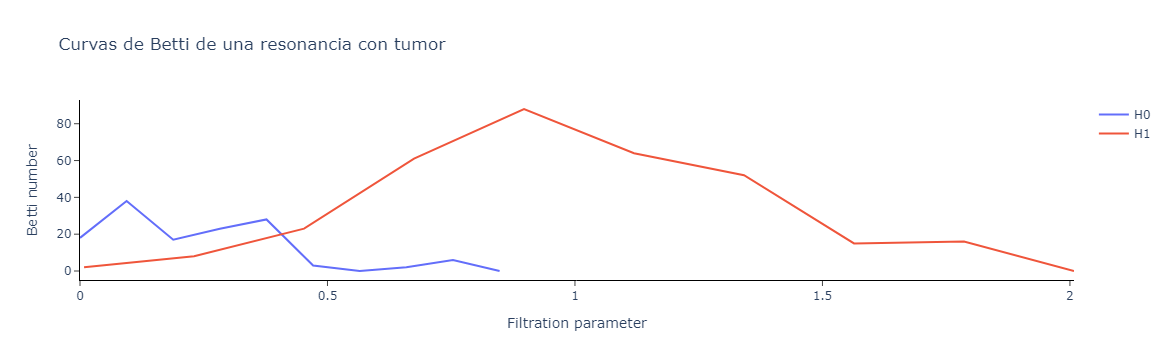

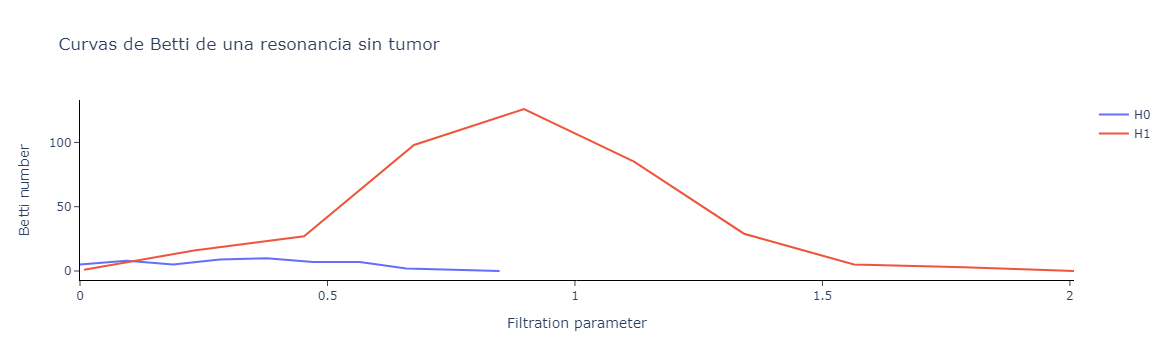

In [144]:
im_yes_betti = betti_curve.fit_transform(im_yes_filtered)
im_no_betti = betti_curve.fit_transform(im_no_filtered)

im_yes_betti_plot = betti_curve.plot(im_yes_betti, plotly_params={'layout':{'title':'Curvas de Betti de una resonancia con tumor'}})
im_no_betti_plot = betti_curve.plot(im_no_betti,  plotly_params={'layout':{'title':'Curvas de Betti de una resonancia sin tumor'}})

im_yes_betti_plot.show()
im_no_betti_plot.show()

### Núcleo de calor

In [176]:
from gtda.diagrams import HeatKernel

heat_kernel = HeatKernel(sigma=0.04, n_bins=100, n_jobs=-1)

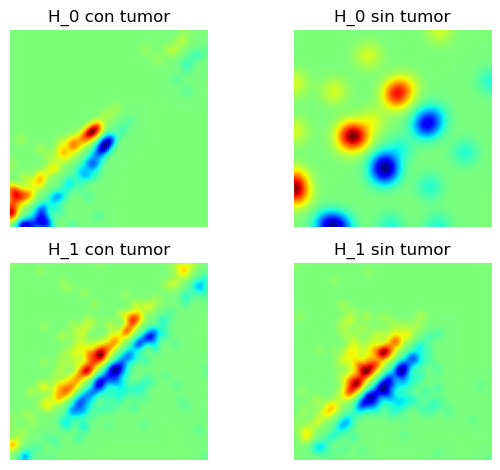

In [178]:
im_yes_heat = heat_kernel.fit_transform(im_yes_filtered)
im_no_heat = heat_kernel.fit_transform(im_no_filtered)

im_yes_heat_plot_0 = heat_kernel.plot(im_yes_heat, homology_dimension_idx=0)
im_yes_heat_plot_1 = heat_kernel.plot(im_yes_heat, homology_dimension_idx=1)
im_no_heat_plot_0 = heat_kernel.plot(im_no_heat, homology_dimension_idx=0)
im_no_heat_plot_1 = heat_kernel.plot(im_no_heat, homology_dimension_idx=1)

plt.figure()

plt.subplot(2, 2, 1)
plt.title('H_0 con tumor')
plt.imshow(im_yes_heat_plot_0['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('H_0 sin tumor')
plt.imshow(im_no_heat_plot_0['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('H_1 con tumor')
plt.imshow(im_yes_heat_plot_1['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('H_1 sin tumor')
plt.imshow(im_no_heat_plot_1['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.tight_layout()

### Filtro radial

In [9]:
from gtda.images import RadialFiltration
from itertools import product
import numpy as np

centers = product((37, 112, 187), (37, 112, 187))
centers = list(centers)
centers.sort(key=lambda x: x[1])
radial_filtrations = [RadialFiltration(center=np.asarray(center), n_jobs=-1) for center in centers]

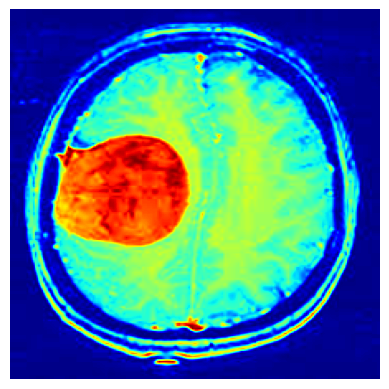

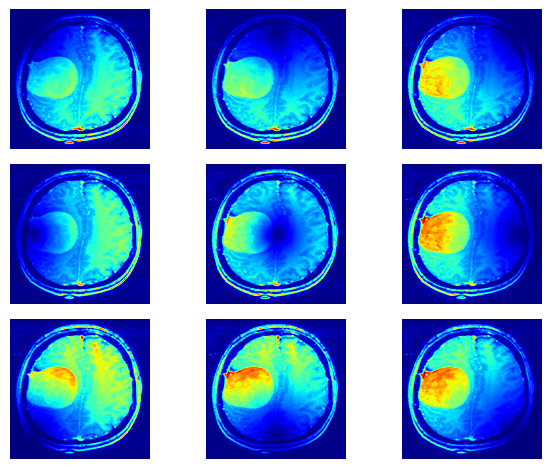

In [10]:
im_yes = images_yes[0][None, :, :]

plt.imshow(im_yes[0], cmap='jet')
plt.axis('off')
plt.figure()
for i, filtration in enumerate(radial_filtrations):
    im_yes_radial = filtration.fit_transform(im_yes)
    im_yes_radial_plot = filtration.plot(im_yes_radial, colorscale='jet')
    
    plt.subplot(3, 3, i+1)
    plt.imshow(im_yes_radial_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
plt.tight_layout()

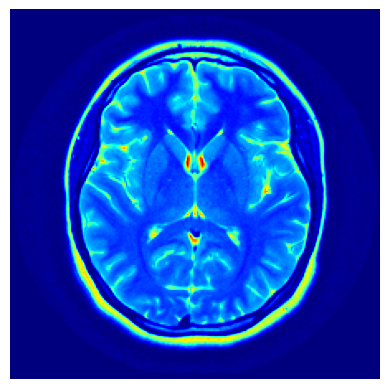

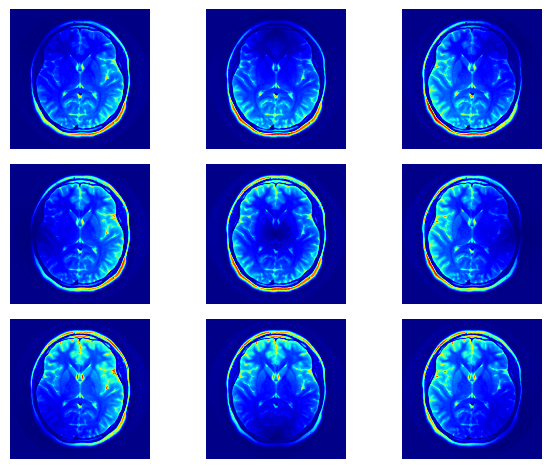

In [11]:
from gtda.images import RadialFiltration
from itertools import product

im_no = images_no[0][None, :, :]

plt.imshow(im_no[0], cmap='jet')
plt.axis('off')
plt.figure()
for i, filtration in enumerate(radial_filtrations):
    im_no_radial = filtration.fit_transform(im_no)
    im_no_radial_plot = filtration.plot(im_no_radial, colorscale='jet')
    
    plt.subplot(3, 3, i+1)
    plt.imshow(im_no_radial_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
plt.tight_layout()

In [14]:
im_yes_heat = heat_kernel.fit_transform(im_yes_scaled)
im_no_heat = heat_kernel.fit_transform(im_no_scaled)

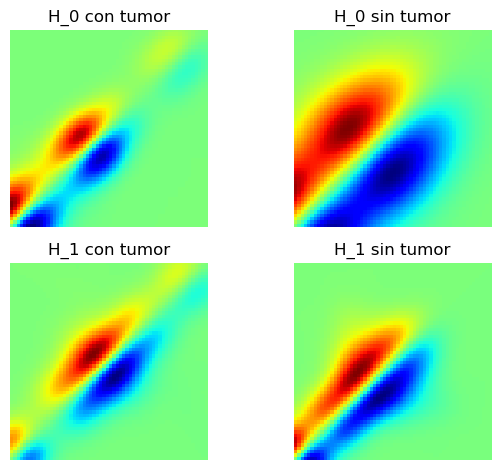

In [15]:
im_yes_heat_plot_0 = heat_kernel.plot(im_yes_heat, homology_dimension_idx=0)
im_yes_heat_plot_1 = heat_kernel.plot(im_yes_heat, homology_dimension_idx=1)
im_no_heat_plot_0 = heat_kernel.plot(im_no_heat, homology_dimension_idx=0)
im_no_heat_plot_1 = heat_kernel.plot(im_no_heat, homology_dimension_idx=1)

plt.figure()

plt.subplot(2, 2, 1)
plt.title('H_0 con tumor')
plt.imshow(im_yes_heat_plot_0['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('H_0 sin tumor')
plt.imshow(im_no_heat_plot_0['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('H_1 con tumor')
plt.imshow(im_yes_heat_plot_1['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('H_1 sin tumor')
plt.imshow(im_no_heat_plot_1['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.tight_layout()

### Distintos filtros de densidad con un radio pequeño

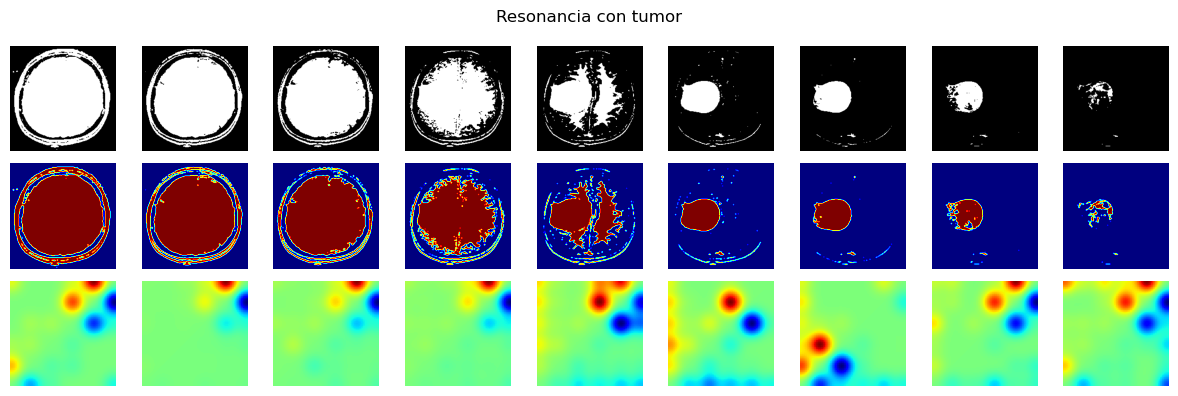

In [17]:
from gtda.images import Binarizer
from gtda.images import DensityFiltration
density_filtration = DensityFiltration(radius=1, metric='euclidean', n_jobs=-1)

plt.figure(figsize=(12, 4))
plt.suptitle('Resonancia con tumor')
for threshold in range(1, 10):
    binarizer = Binarizer(threshold=threshold/10, n_jobs=-1)
    im_yes_binarized = binarizer.fit_transform(im_yes)
    im_yes_binarized_plot = binarizer.plot(im_yes_binarized)
    plt.subplot(3, 9, threshold)
    plt.imshow(im_yes_binarized_plot['data'][0]['z'], cmap='gray')
    plt.axis('off')

    im_yes_density = density_filtration.fit_transform(im_yes_binarized)
    im_yes_density_plot = density_filtration.plot(im_yes_density)
    plt.subplot(3, 9, threshold+9)
    plt.imshow(im_yes_density_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
    im_yes_cubical = cubical_persistence.fit_transform(im_yes_density)
    im_yes_cubical_scaled = scaler.fit_transform(im_yes_cubical)
    im_yes_cubical_heat = heat_kernel.fit_transform(im_yes_cubical_scaled)
    im_yes_cubical_heat_plot = heat_kernel.plot(im_yes_cubical_heat, homology_dimension_idx=1)
    plt.subplot(3, 9, threshold+18)
    plt.imshow(im_yes_cubical_heat_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
plt.tight_layout()

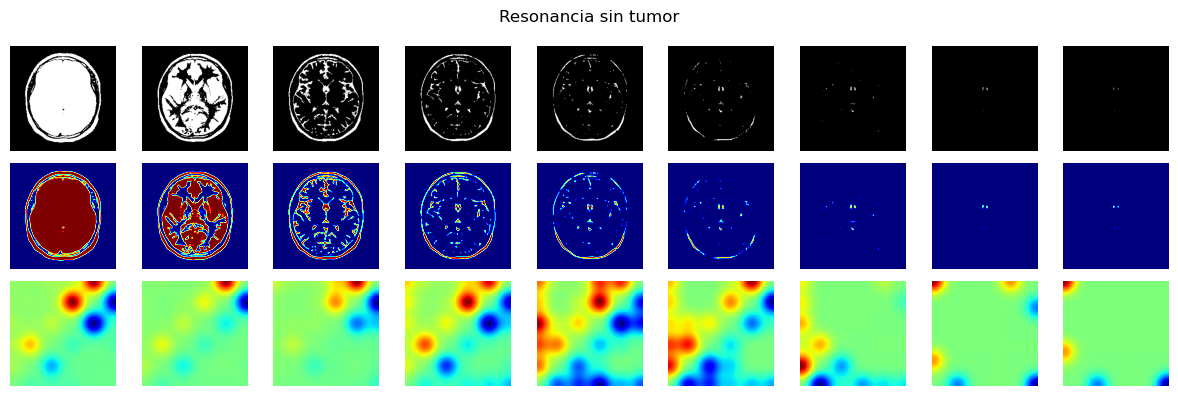

In [18]:
plt.figure(figsize=(12, 4))
plt.suptitle('Resonancia sin tumor')
for threshold in range(1, 10):
    binarizer = Binarizer(threshold=threshold/10, n_jobs=-1)
    im_no_binarized = binarizer.fit_transform(im_no)
    im_no_binarized_plot = binarizer.plot(im_no_binarized)
    plt.subplot(3, 9, threshold)
    plt.imshow(im_no_binarized_plot['data'][0]['z'], cmap='gray')
    plt.axis('off')

    im_no_density = density_filtration.fit_transform(im_no_binarized)
    im_no_density_plot = density_filtration.plot(im_no_density)
    plt.subplot(3, 9, threshold+9)
    plt.imshow(im_no_density_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
    im_no_cubical = cubical_persistence.fit_transform(im_no_density)
    im_no_cubical_scaled = scaler.fit_transform(im_no_cubical)
    im_no_cubical_heat = heat_kernel.fit_transform(im_no_cubical_scaled)
    im_no_cubical_heat_plot = heat_kernel.plot(im_no_cubical_heat, homology_dimension_idx=1)
    plt.subplot(3, 9, threshold+18)
    plt.imshow(im_no_cubical_heat_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
plt.tight_layout()

### Distintos filtros de densidad con un radio grande

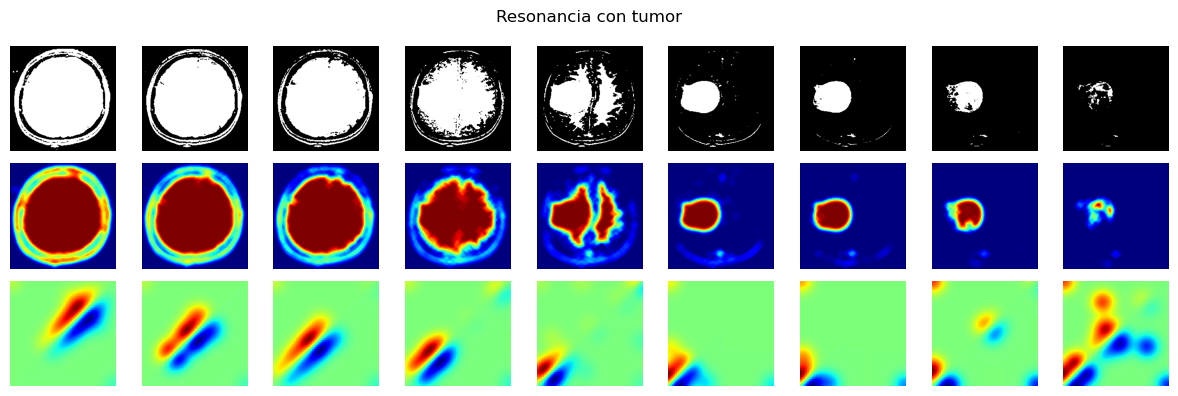

In [25]:
density_filtration = DensityFiltration(radius=10, metric='cityblock', n_jobs=-1)

plt.figure(figsize=(12, 4))
plt.suptitle('Resonancia con tumor')
for threshold in range(1, 10):
    binarizer = Binarizer(threshold=threshold/10, n_jobs=-1)
    im_yes_binarized = binarizer.fit_transform(im_yes)
    im_yes_binarized_plot = binarizer.plot(im_yes_binarized)
    plt.subplot(3, 9, threshold)
    plt.imshow(im_yes_binarized_plot['data'][0]['z'], cmap='gray')
    plt.axis('off')

    im_yes_density = density_filtration.fit_transform(im_yes_binarized)
    im_yes_density_plot = density_filtration.plot(im_yes_density)
    plt.subplot(3, 9, threshold+9)
    plt.imshow(im_yes_density_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
    im_yes_cubical = cubical_persistence.fit_transform(im_yes_density)
    im_yes_cubical_scaled = scaler.fit_transform(im_yes_cubical)
    im_yes_cubical_heat = heat_kernel.fit_transform(im_yes_cubical_scaled)
    im_yes_cubical_heat_plot = heat_kernel.plot(im_yes_cubical_heat, homology_dimension_idx=1)
    plt.subplot(3, 9, threshold+18)
    plt.imshow(im_yes_cubical_heat_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
plt.tight_layout()

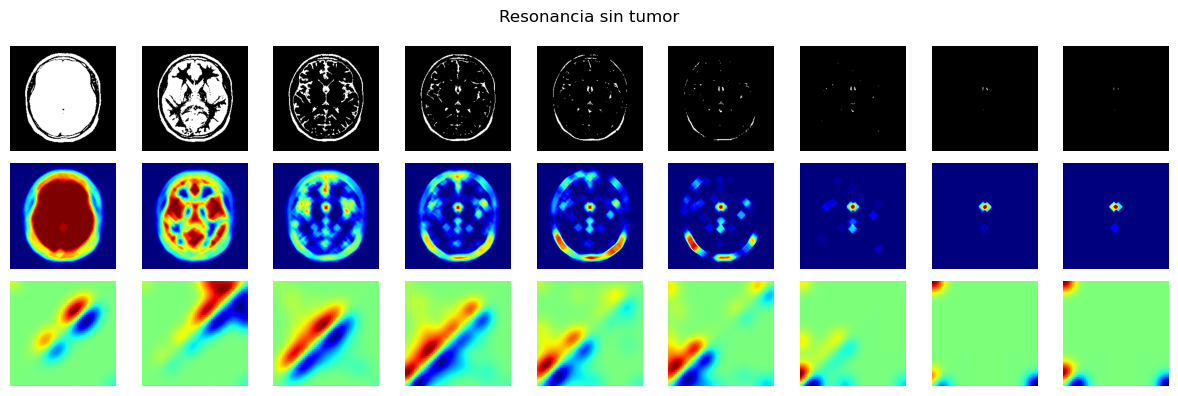

In [29]:
plt.figure(figsize=(12, 4))
plt.suptitle('Resonancia sin tumor')
for threshold in range(1, 10):
    binarizer = Binarizer(threshold=threshold/10, n_jobs=-1)
    im_no_binarized = binarizer.fit_transform(im_no)
    im_no_binarized_plot = binarizer.plot(im_no_binarized)
    plt.subplot(3, 9, threshold)
    plt.imshow(im_no_binarized_plot['data'][0]['z'], cmap='gray')
    plt.axis('off')

    im_no_density = density_filtration.fit_transform(im_no_binarized)
    im_no_density_plot = density_filtration.plot(im_no_density)
    plt.subplot(3, 9, threshold+9)
    plt.imshow(im_no_density_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
    im_no_cubical = cubical_persistence.fit_transform(im_no_density)
    im_no_cubical_scaled = scaler.fit_transform(im_no_cubical)
    im_no_cubical_heat = heat_kernel.fit_transform(im_no_cubical_scaled)
    im_no_cubical_heat_plot = heat_kernel.plot(im_no_cubical_heat, homology_dimension_idx=1)
    plt.subplot(3, 9, threshold+18)
    plt.imshow(im_no_cubical_heat_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
plt.tight_layout()

## Diseño de un Pipeline

In [31]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn import set_config
from gtda.diagrams import PersistenceEntropy, Amplitude

thresholds = np.arange(0.1, 1, 0.1)
centers = product({37, 112 ,187}, {37, 112 ,187})

binarizers = ([Binarizer(threshold=threshold, n_jobs=-1) for threshold in thresholds])
radial_filtrations = ([RadialFiltration(center=np.asarray(center), n_jobs=-1) for center in centers])
density_filtrations = ([DensityFiltration(radius=1, metric='euclidean', n_jobs=-1), 
                        DensityFiltration(radius=10, metric='cityblock', n_jobs=-1)])

steps_original = [
    [
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1)
    ] for filtration in radial_filtrations 
]

steps_binarizer = [
    [
        binarizer,
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1)
    ] for filtration in density_filtrations
    for binarizer in binarizers
]

metric_iter = [
    {'metric':'bottleneck', 'metric_params':{}},
    {'metric':'wasserstein', 'metric_params':{'p':1}},
    {'metric':'wasserstein', 'metric_params':{'p':2}},
    {'metric':'landscape', 'metric_params':{'p':1, 'n_layers':1, 'n_bins':100}},
    {'metric':'landscape', 'metric_params':{'p':1, 'n_layers':2, 'n_bins':100}},
    {'metric':'landscape', 'metric_params':{'p':2, 'n_layers':1, 'n_bins':100}},
    {'metric':'landscape', 'metric_params':{'p':2, 'n_layers':2, 'n_bins':100}},
    {'metric':'betti', 'metric_params':{'p':1, 'n_bins':100}},
    {'metric':'betti', 'metric_params':{'p':2, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':1, 'sigma':1.6, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':1, 'sigma':3.2, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':2, 'sigma':1.6, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':2, 'sigma':3.2, 'n_bins':100}}
]
amplitudes = ([Amplitude(**metric, n_jobs=-1) for metric in metric_iter])
amplitudes_union = make_union(*[PersistenceEntropy(nan_fill_value=-1)] + amplitudes)

pipe_original = make_union(
    *[make_pipeline(*step, amplitudes_union) for step in steps_original], n_jobs=-1
)

pipe_binarizer = make_union(
    *[make_pipeline(*step, amplitudes_union) for step in steps_binarizer], n_jobs=-1
)

tda_pipeline = make_union(pipe_original, pipe_binarizer)

set_config(display='diagram')
tda_pipeline

FeatureUnion(transformer_list=[('featureunion-1',
                                FeatureUnion(n_jobs=-1,
                                             transformer_list=[('pipeline-1',
                                                                Pipeline(steps=[('radialfiltration',
                                                                                 RadialFiltration(center=array([112, 112]),
                                                                                                  n_jobs=-1)),
                                                                                ('cubicalpersistence',
                                                                                 CubicalPersistence(n_jobs=-1)),
                                                                                ('scaler',
                                                                                 Scaler(n_jobs=-1)),
                                                                                ('featureunion',
                                                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                                                 Persis...
                                                                                                                           metric_params={'n_bins': 100,
                                                                                                                                          'p': 1,
                                                                                                                                          'sigma': 1.6},
                                                                                                                           n_jobs=-1)),
                                                                                                                ('amplitude-11',
                                                                                                                 Amplitude(metric='heat',
                                                                                                                           metric_params={'n_bins': 100,
                                                                                                                                          'p': 1,
                                                                                                                                          'sigma': 3.2},
                                                                                                                           n_jobs=-1)),
                                                                                                                ('amplitude-12',
                                                                                                                 Amplitude(metric='heat',
                                                                                                                           metric_params={'n_bins': 100,
                                                                                                                                          'p': 2,
                                                                                                                                          'sigma': 1.6},
                                                                                                                           n_jobs=-1)),
                                                                                                                ('amplitude-13',
                                                                                                                 Amplitude(metric='heat',
                                                                                                                           metric_params={'n_bins': 100,

In [32]:
%%time
im_yes_pipeline = tda_pipeline.fit_transform(im_yes)
im_yes_pipeline.shape

CPU times: total: 156 ms
Wall time: 20.5 s


(1, 756)